In [11]:
import math
import torch
import gpytorch
from gpytorch.models.gplvm import bayesian_gplvm
from matplotlib import pyplot as plt
from ssapp.data.AntennaDatasetLoaders import load_serialized_dataset, set_global_random_seed
from ssapp.Utils import train_test_data_split
from torch.utils.data.dataloader import DataLoader
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
set_global_random_seed(42)

dataset = load_serialized_dataset('PatchAntennaDataset1')
train_dataset,test_dataset = train_test_data_split(dataset)
train_dataloader = DataLoader(train_dataset,batch_size = len(train_dataset))
test_dataloader = DataLoader(test_dataset,batch_size = len(test_dataset))

train_parameters, train_fields = next(iter(train_dataloader))

train_parameters = train_parameters.reshape(len(train_parameters),-1)
train_parameters = train_parameters.float()


train_fields = train_fields.reshape(len(train_fields),-1)



test_parameters, test_fields = next(iter(test_dataloader))

test_parameters = test_parameters.float()
test_fields = test_fields.reshape(len(test_fields),-1)


N_DIM = 2
train_fields = train_fields[:,0:N_DIM]
test_fields = test_fields[:,0:N_DIM]
print(train_parameters.shape, train_fields.shape)

torch.Size([240, 3]) torch.Size([240, 2])


In [13]:
class BatchIndependentMultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super().__init__(train_x, train_y, likelihood)

        BATCH_SHAPE = torch.Size([N_DIM])
        self.mean_module = gpytorch.means.ConstantMean(batch_shape=BATCH_SHAPE)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(batch_shape=BATCH_SHAPE),
            batch_shape=BATCH_SHAPE
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal.from_batch_mvn(
            gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        )


print(train_parameters.shape)

likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=N_DIM)
model = BatchIndependentMultitaskGPModel(train_parameters.float(), train_fields.float(), likelihood)


torch.Size([240, 3])


In [14]:

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

training_iterations  = 50

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()

    output = model(train_parameters)

    loss = -mll(output, train_fields.float())
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()



c:\Users\Niels\.conda\envs\Kandidatspeciale\lib\site-packages\gpytorch\lazy\triangular_lazy_tensor.py:130: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\BatchLinearAlgebra.cpp:1672.)
  res = torch.triangular_solve(right_tensor, self.evaluate(), upper=self.upper).solution


Iter 1/50 - Loss: 1.173
Iter 2/50 - Loss: 1.132
Iter 3/50 - Loss: 1.090
Iter 4/50 - Loss: 1.048
Iter 5/50 - Loss: 1.005
Iter 6/50 - Loss: 0.961
Iter 7/50 - Loss: 0.917
Iter 8/50 - Loss: 0.873
Iter 9/50 - Loss: 0.828
Iter 10/50 - Loss: 0.783
Iter 11/50 - Loss: 0.737
Iter 12/50 - Loss: 0.691
Iter 13/50 - Loss: 0.645
Iter 14/50 - Loss: 0.597
Iter 15/50 - Loss: 0.550
Iter 16/50 - Loss: 0.502
Iter 17/50 - Loss: 0.454
Iter 18/50 - Loss: 0.405
Iter 19/50 - Loss: 0.356
Iter 20/50 - Loss: 0.306
Iter 21/50 - Loss: 0.257
Iter 22/50 - Loss: 0.206
Iter 23/50 - Loss: 0.156
Iter 24/50 - Loss: 0.105
Iter 25/50 - Loss: 0.054
Iter 26/50 - Loss: 0.003
Iter 27/50 - Loss: -0.048
Iter 28/50 - Loss: -0.100
Iter 29/50 - Loss: -0.151
Iter 30/50 - Loss: -0.203
Iter 31/50 - Loss: -0.255
Iter 32/50 - Loss: -0.307
Iter 33/50 - Loss: -0.359
Iter 34/50 - Loss: -0.412
Iter 35/50 - Loss: -0.464
Iter 36/50 - Loss: -0.516
Iter 37/50 - Loss: -0.569
Iter 38/50 - Loss: -0.621
Iter 39/50 - Loss: -0.673
Iter 40/50 - Loss: -0

C:\Users\Niels\AppData\Local\Temp/ipykernel_194504/818858518.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  relRMSE_pytorch(torch.tensor(mean),train_fields)


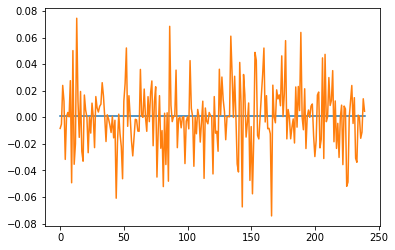

In [18]:
from ssapp.data.Metrics import relRMSE_pytorch
# Set into eval mode
model.train()
likelihood.train()

# Make predictions
with torch.no_grad():

    output = model(train_parameters)
    predictions = likelihood(output)
    mean = predictions.mean
    lower, upper = predictions.confidence_region()


relRMSE_pytorch(torch.tensor(mean),train_fields)


from matplotlib import pyplot as plt

plt.figure()
plt.plot(mean[:,0])
plt.plot(train_fields[:,0])